<a href="https://colab.research.google.com/github/TMhdSofyan/Applied-Random-Forest-for-LSWI-Feature-Importance/blob/main/03_Porosity_Prediction_5Scenarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install jcopml

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [4]:
well3069 = pd.read_csv('/content/drive/MyDrive/02_PorosityPrediction/Data/WELL3069.csv', index_col = 'Interval')
well3153 = pd.read_csv('/content/drive/MyDrive/02_PorosityPrediction/Data/WELL3153.csv', index_col = 'Interval')

In [5]:
df1 = well3069.copy()
df2 = well3153.copy()

In [6]:
df1.drop(columns=["Unnamed: 0", 'Well', 'Top Depth', 'Bottom Depth'], inplace = True)
df2.drop(columns=["Unnamed: 0", 'Well', 'Top Depth', 'Bottom Depth'], inplace = True)

In [8]:
df1.head()

,Feat1,Feat2,Feat3,Feat4,Feat5,Feat6,Feat7,Feat8,Feat9,Feat10,...,Feat57,Feat58,Feat59,Feat60,Feat61,Feat62,Feat63,Feat64,Porosity,Category
Interval,,,,,,,,,,,,,,,,,,,,,
1,0.148299,0.580686,0.016974,0,0.814183,0,0.471686,0.569079,0.496425,0.171245,...,0.926652,0.053066,0.273418,0.269324,0.294667,0.238324,0.205344,0.164740,2.663,Training
2,0.142274,0.616516,0.017499,0,0.796514,0,0.466511,0.673229,0.497532,0.172387,...,0.930082,0.047496,0.283339,0.269407,0.303216,0.240902,0.195298,0.162870,4.254,Training
3,0.153650,0.622328,0.016174,0,0.828897,0,0.504620,0.640805,0.534978,0.171929,...,0.919148,0.047287,0.275917,0.276077,0.306124,0.235974,0.210334,0.172289,5.024,Training
4,0.141034,0.653016,0.021145,0,0.749869,0,0.474010,0.928275,0.505225,0.157319,...,1.034046,0.047767,0.330523,0.267975,0.312241,0.251193,0.177785,0.159958,6.728,Training
5,0.155585,0.687302,0.020452,0,0.759639,0,0.468802,0.904675,0.504026,0.156041,...,1.157788,0.053867,0.342527,0.261999,0.298657,0.278259,0.189913,0.164179,5.923,Training


In [9]:
df2.head()

,Feat1,Feat2,Feat3,Feat4,Feat5,Feat6,Feat7,Feat8,Feat9,Feat10,...,Feat57,Feat58,Feat59,Feat60,Feat61,Feat62,Feat63,Feat64,Porosity,Category
Interval,,,,,,,,,,,,,,,,,,,,,
1,0.111107,0.637342,0.116230,0,0.323171,0,0.138028,1.019930,0.192078,0.069187,...,1.877978,0.053170,0.762293,0.143510,0.147707,0.541232,0.178420,0.061673,3.717,Testing
2,0.109627,0.617905,0.074388,0,0.422775,0,0.187225,1.102177,0.260711,0.091224,...,1.547184,0.049873,0.582218,0.161414,0.191991,0.514111,0.165416,0.082634,5.963,Testing
3,0.116730,0.651679,0.086557,0,0.405075,0,0.187366,1.109188,0.251022,0.092435,...,1.642362,0.054652,0.643235,0.162801,0.184983,0.518119,0.175866,0.077211,9.075,Testing
4,0.115027,0.697577,0.049390,0,0.457828,0,0.238469,1.154134,0.346774,0.098410,...,1.484510,0.043948,0.557853,0.196529,0.233154,0.443506,0.156372,0.103130,9.664,Testing
5,0.115816,0.704929,0.044998,0,0.461323,0,0.229203,1.180574,0.349827,0.093268,...,1.423451,0.042079,0.527821,0.184408,0.231423,0.453484,0.159318,0.105856,10.708,Testing


#**Scenario 1 - WELL3069**
Training Data = Depth 13720 - 13910 |
Testing Data = Depth 13910 - 13990

In [65]:

train_data = df1[df1['Category'] == 'Training']
test_data = df1[df1['Category'] == 'Testing']


X_train = train_data.drop(['Category', 'Porosity'], axis=1)
y_train = train_data.Porosity
X_test = test_data.drop(['Category', 'Porosity'], axis=1)
y_test = test_data.Porosity

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20, 64), (8, 64), (20,), (8,))

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [67]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 48, 'algo__max_features': 0.8219772826786358, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 188}
0.9571358282906045 -15.417180092573716 -0.023369151443362268


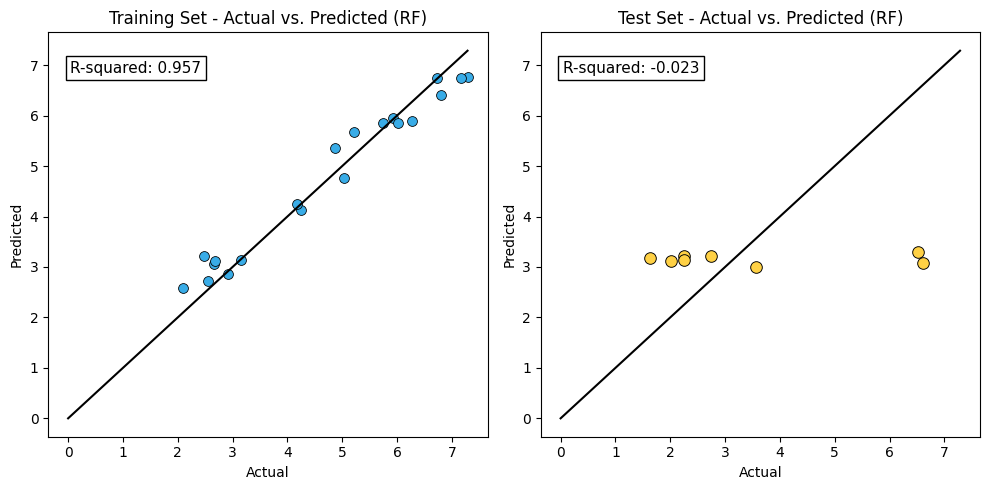

In [68]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

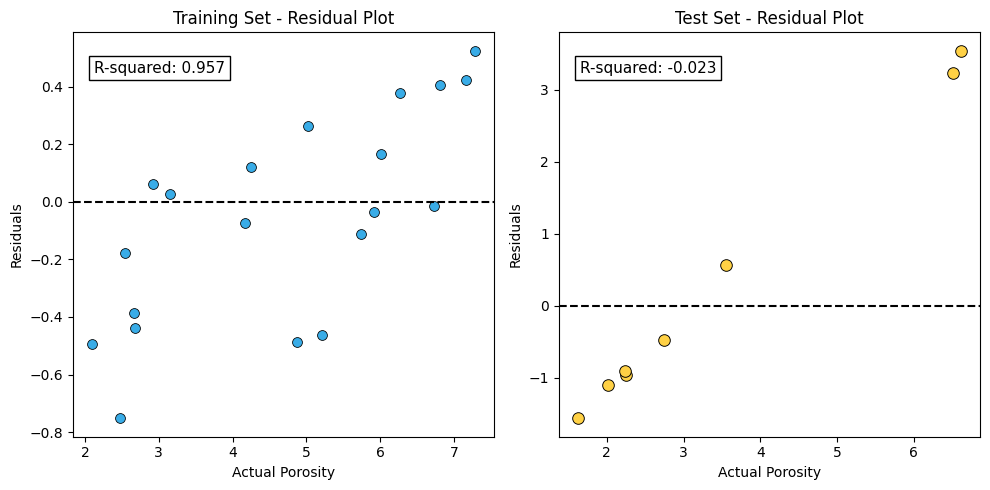

In [69]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create dataframes with the residuals for training and test sets
train_residual_data = pd.DataFrame({'Residuals': train_residuals})
test_residual_data = pd.DataFrame({'Residuals': test_residuals})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot training set residuals
sns.scatterplot(data=train_residual_data, x=y_train, y=train_residuals, ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_title('Training Set - Residual Plot')
axes[0].set_xlabel('Actual Porosity')
axes[0].set_ylabel('Residuals')

# Plot test set residuals
sns.scatterplot(data=test_residual_data, x=y_test, y=test_residuals, ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Test Set - Residual Plot')
axes[1].set_xlabel('Actual Porosity')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

--------------

#**Scenario 2 - WELL 3153**
Training Data = Depth 14300 - 14610 | Testing Data = Depth 14240 - 14300

In [70]:

train_data = df2[df2['Category'] == 'Training']
test_data = df2[df2['Category'] == 'Testing']


X_train = train_data.drop(['Category', 'Porosity'], axis=1)
y_train = train_data.Porosity
X_test = test_data.drop(['Category', 'Porosity'], axis=1)
y_test = test_data.Porosity

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31, 64), (7, 64), (31,), (7,))

In [71]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 26, 'algo__max_features': 0.4810613326357327, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 107}
0.851270332326334 -0.31281435567154264 -0.3512317959510536


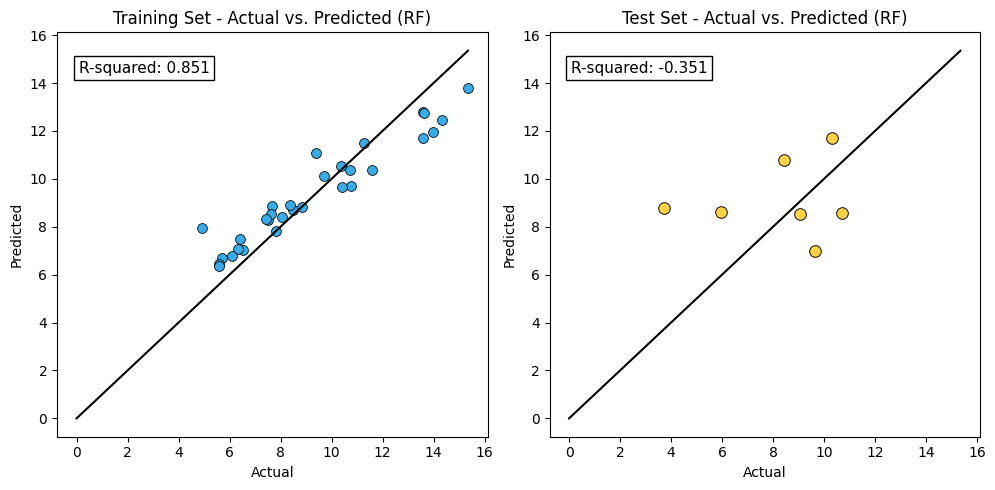

In [72]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

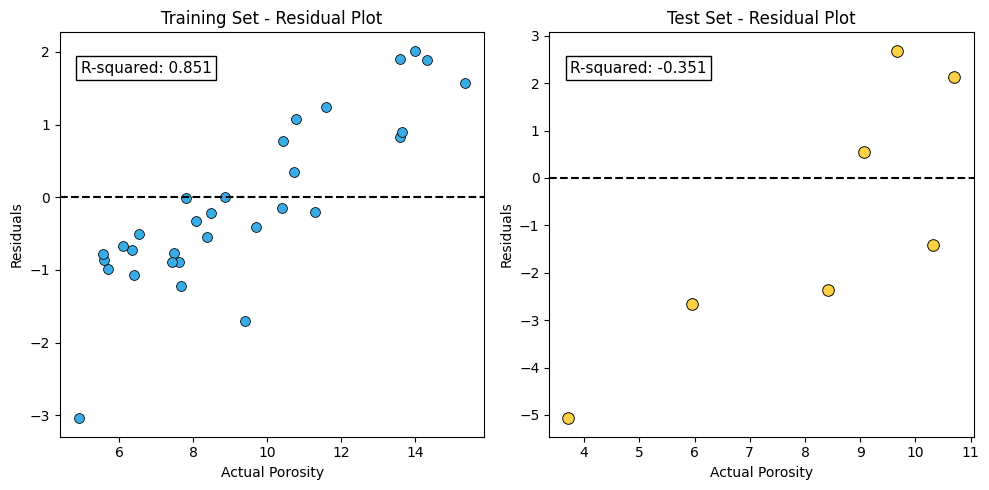

In [73]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create dataframes with the residuals for training and test sets
train_residual_data = pd.DataFrame({'Residuals': train_residuals})
test_residual_data = pd.DataFrame({'Residuals': test_residuals})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot training set residuals
sns.scatterplot(data=train_residual_data, x=y_train, y=train_residuals, ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_title('Training Set - Residual Plot')
axes[0].set_xlabel('Actual Porosity')
axes[0].set_ylabel('Residuals')

# Plot test set residuals
sns.scatterplot(data=test_residual_data, x=y_test, y=test_residuals, ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Test Set - Residual Plot')
axes[1].set_xlabel('Actual Porosity')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

_______

#**Scenario 3**
Using WELL 1069 as training data & WELL 3153 as testing data

In [74]:
X_train = df1.drop(['Category', 'Porosity'], axis=1)
y_train = df1.Porosity
X_test = df2.drop(['Category', 'Porosity'], axis=1)
y_test = df2.Porosity

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28, 64), (38, 64), (28,), (38,))

In [75]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 27, 'algo__max_features': 0.7561064512368887, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 104}
0.9287658539784759 -0.23506993854815364 -2.7914579162217477


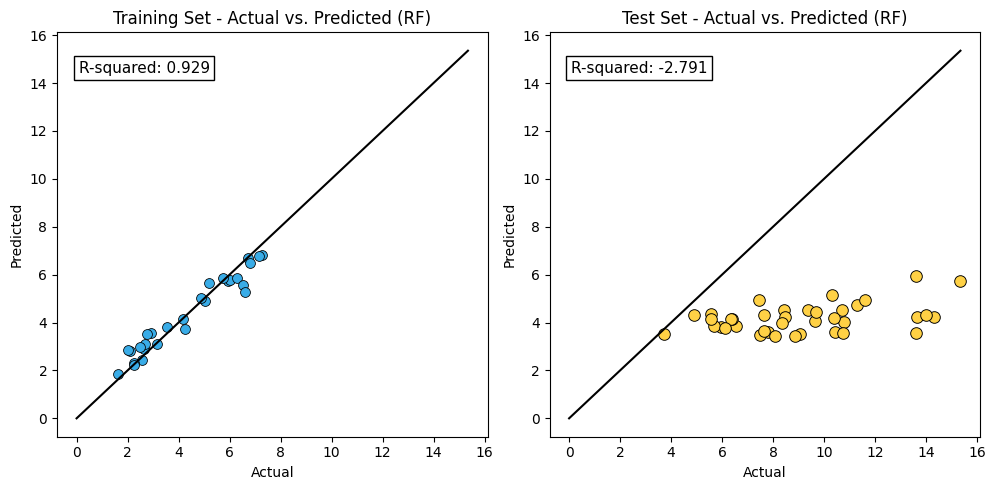

In [76]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

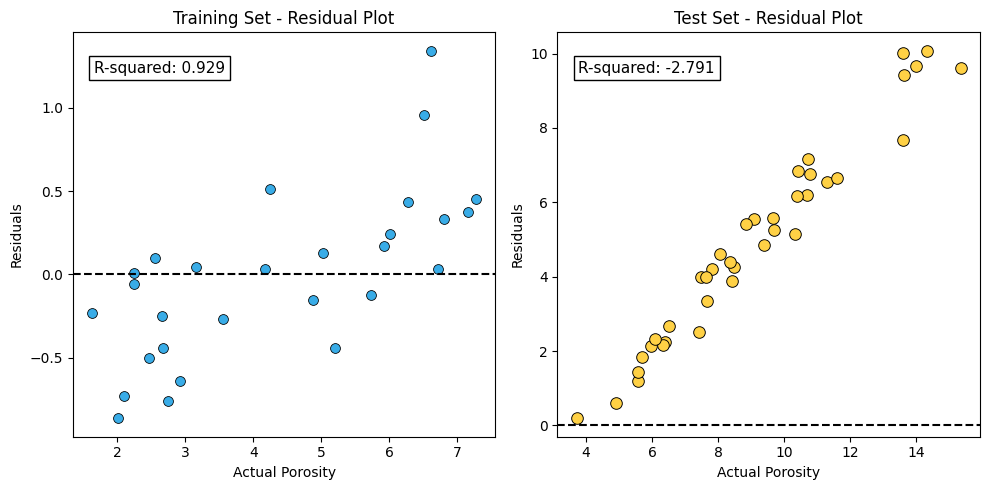

In [77]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create dataframes with the residuals for training and test sets
train_residual_data = pd.DataFrame({'Residuals': train_residuals})
test_residual_data = pd.DataFrame({'Residuals': test_residuals})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot training set residuals
sns.scatterplot(data=train_residual_data, x=y_train, y=train_residuals, ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_title('Training Set - Residual Plot')
axes[0].set_xlabel('Actual Porosity')
axes[0].set_ylabel('Residuals')

# Plot test set residuals
sns.scatterplot(data=test_residual_data, x=y_test, y=test_residuals, ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Test Set - Residual Plot')
axes[1].set_xlabel('Actual Porosity')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

#**Scenario 4**
Using WELL 3153 as training data & WELL 1069 as testing data

In [78]:
X_train = df2.drop(['Category', 'Porosity'], axis=1)
y_train = df2.Porosity
X_test = df1.drop(['Category', 'Porosity'], axis=1)
y_test = df1.Porosity

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38, 64), (28, 64), (38,), (28,))

In [79]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 42, 'algo__max_features': 0.5687508340232413, 'algo__min_samples_leaf': 8, 'algo__n_estimators': 184}
0.42321562431153237 -0.7385883396971321 -10.38886824044967


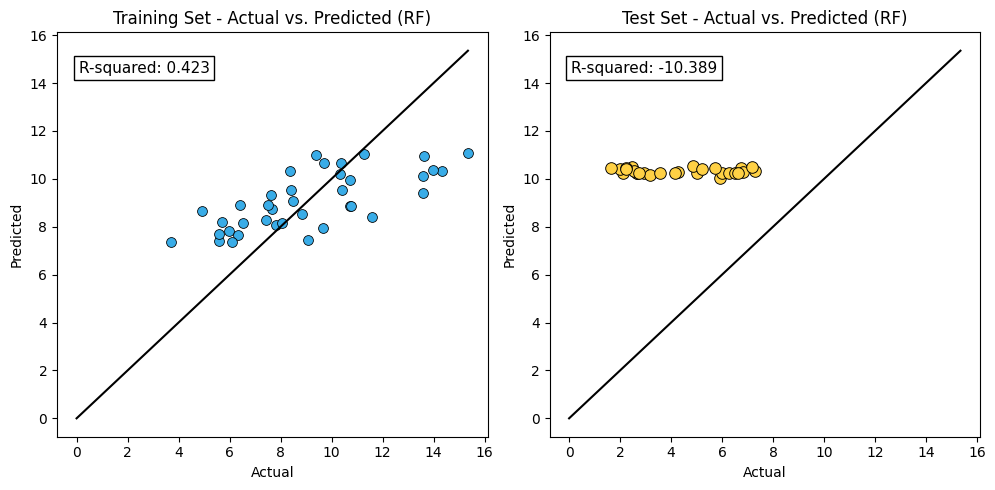

In [80]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

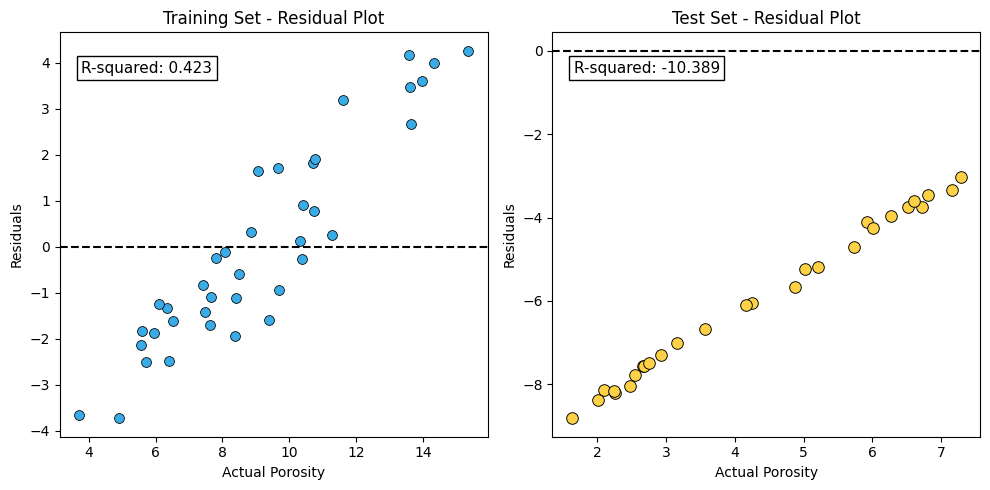

In [81]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create dataframes with the residuals for training and test sets
train_residual_data = pd.DataFrame({'Residuals': train_residuals})
test_residual_data = pd.DataFrame({'Residuals': test_residuals})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot training set residuals
sns.scatterplot(data=train_residual_data, x=y_train, y=train_residuals, ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_title('Training Set - Residual Plot')
axes[0].set_xlabel('Actual Porosity')
axes[0].set_ylabel('Residuals')

# Plot test set residuals
sns.scatterplot(data=test_residual_data, x=y_test, y=test_residuals, ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Test Set - Residual Plot')
axes[1].set_xlabel('Actual Porosity')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

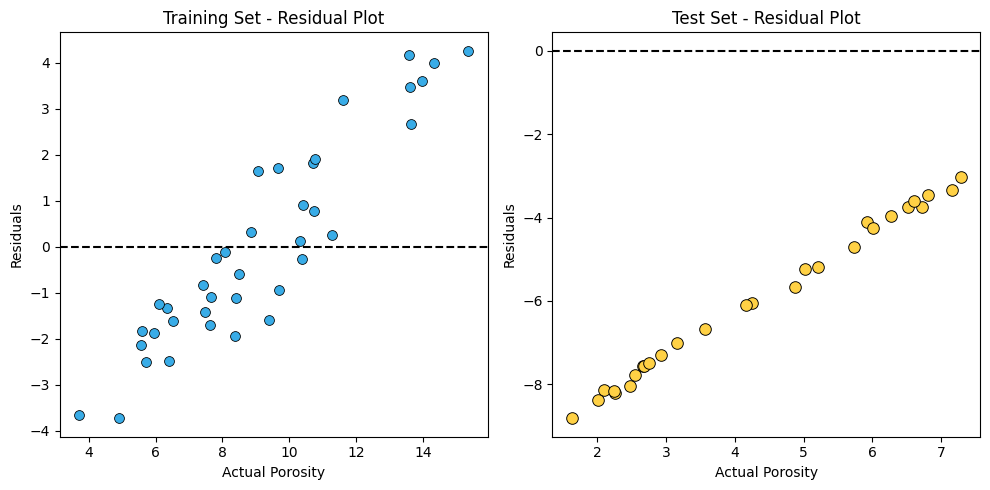

In [82]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create dataframes with the residuals for training and test sets
train_residual_data = pd.DataFrame({'Residuals': train_residuals})
test_residual_data = pd.DataFrame({'Residuals': test_residuals})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set residuals
sns.scatterplot(data=train_residual_data, x=y_train, y=train_residuals, ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_title('Training Set - Residual Plot')
axes[0].set_xlabel('Actual Porosity')
axes[0].set_ylabel('Residuals')

# Plot test set residuals
sns.scatterplot(data=test_residual_data, x=y_test, y=test_residuals, ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Test Set - Residual Plot')
axes[1].set_xlabel('Actual Porosity')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()


----------------

#**Scenario 5**
Using WELL 1069 as training data & WELL 3153 as testing data





In [95]:
X_train = df1.drop(['Category', 'Porosity'], axis=1)
y_train = df1.Porosity
X_test = df2.drop(['Category', 'Porosity'], axis=1)
y_test = df2.Porosity

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28, 64), (38, 64), (28,), (38,))

In [96]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 27, 'algo__max_features': 0.7561064512368887, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 104}
0.9287658539784759 -0.23506993854815364 -2.7914579162217477


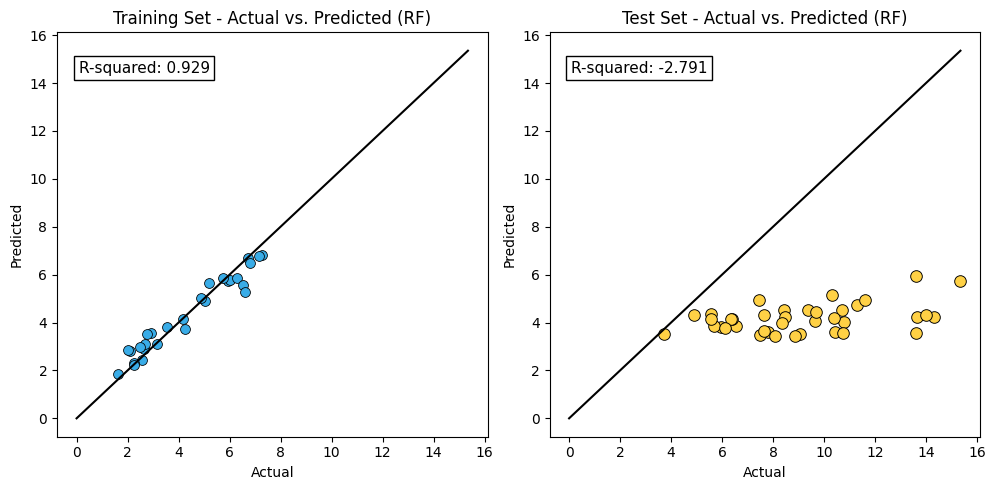

In [97]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

-----------------------

#**Scenario 6**
Using combined training data from both well to predict the combined test data from both well.

In [106]:
train_data1 = df1[df1['Category'] == 'Training']
train_data2 = df2[df2['Category'] == 'Training']

test_data1 = df1[df1['Category'] == 'Testing']
test_data2 = df2[df2['Category'] == 'Testing']

train_data = pd.concat([train_data1, train_data2])
test_data = pd.concat([test_data1, test_data2])

X_train = train_data.drop(['Category', 'Porosity'], axis=1)
y_train = train_data.Porosity
X_test = test_data.drop(['Category', 'Porosity'], axis=1)
y_test = test_data.Porosity

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51, 64), (15, 64), (51,), (15,))

In [107]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 22, 'algo__max_features': 0.1185260448662222, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 187}
0.8717998004489076 0.1611002183128997 0.305260667410162


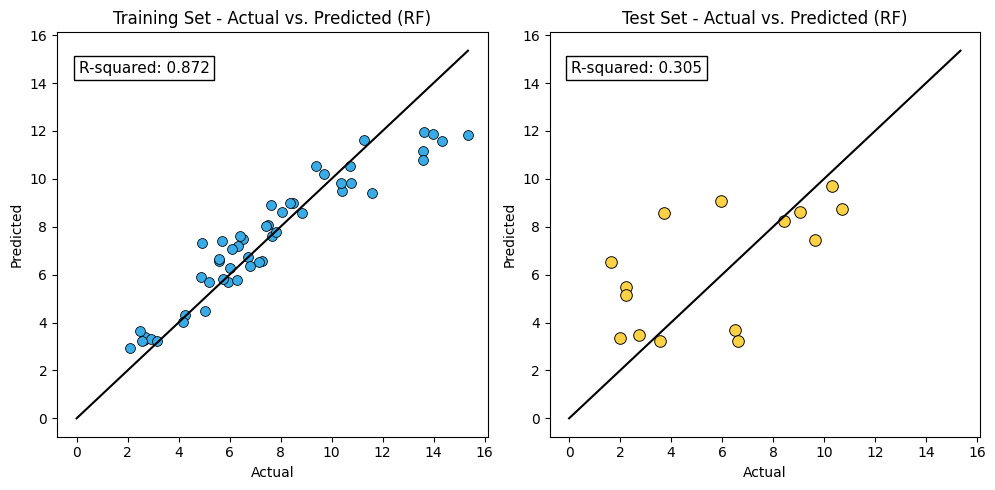

In [108]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

--------------------

#**Scenario 7**
Combine the data of both well = Choose the training and testing data randomly

In [83]:
df = pd.read_csv('/content/drive/MyDrive/02_PorosityPrediction/Data/Siliciclastic.csv', index_col = 'Interval')

In [84]:
df.drop(columns=["Unnamed: 0", 'Well', 'Top Depth', 'Bottom Depth'], inplace = True)

In [85]:
X = df.drop(columns=['Porosity']).values
y = df.Porosity.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52, 64), (14, 64), (52,), (14,))

In [86]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 46, 'algo__max_features': 0.4756699028339012, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 196}
0.7130856372550449 0.3580549852288899 0.7036658763013355


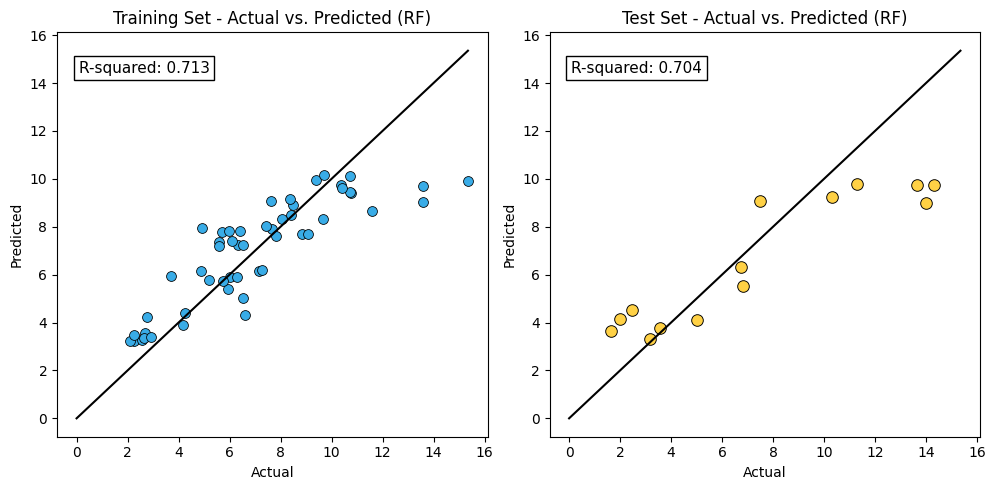

In [94]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/02_PorosityPrediction/Picture/Actual vs Prediction.png', dpi = 600)
plt.show()

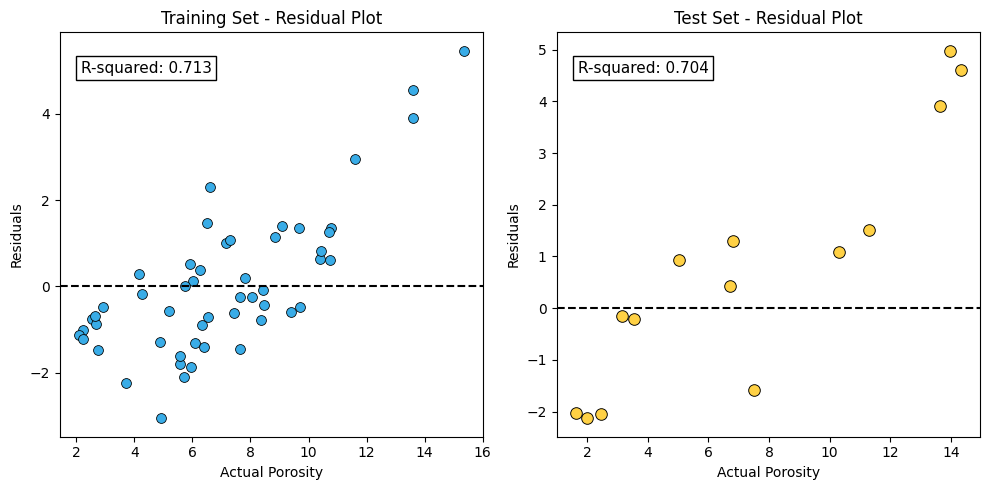

In [88]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create dataframes with the residuals for training and test sets
train_residual_data = pd.DataFrame({'Residuals': train_residuals})
test_residual_data = pd.DataFrame({'Residuals': test_residuals})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot training set residuals
sns.scatterplot(data=train_residual_data, x=y_train, y=train_residuals, ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_title('Training Set - Residual Plot')
axes[0].set_xlabel('Actual Porosity')
axes[0].set_ylabel('Residuals')

# Plot test set residuals
sns.scatterplot(data=test_residual_data, x=y_test, y=test_residuals, ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Test Set - Residual Plot')
axes[1].set_xlabel('Actual Porosity')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()